In [175]:
import tensorflow as tf
import numpy as np
import Functions.dataFrameTools as dataFrameTools
import Functions.processGen as processGen
import pandas as pd
import random
import os
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report

from parametricVAE import dVAE, plot_history,freeze_layers_before, unfreeze_all_layers, loadData2, my_loadData2, loadData2, custom_sigmoid_cross_entropy_loss_with_logits

In [176]:
rated_bikes_df = pd.read_csv('ratings/combined_clean_ratings.csv')


dfn = dataFrameTools.normalizeDF(0).astype('float32')


visual_df =pd.read_csv("../data/clip_sBIKED_reduced.csv", index_col=0)
columns_to_drop = [col for col in visual_df.columns if 'color' in col]
visual_df.drop(columns=columns_to_drop, inplace=True)
boolean_columns = visual_df.select_dtypes(include=['bool']).columns
visual_df[boolean_columns] = visual_df[boolean_columns].astype(int)
visual_df = visual_df.sort_index(axis=1)
visual_df = visual_df.select_dtypes(include=['number'])
constant_columns = [col for col in visual_df.columns if visual_df[col].nunique() == 1]
visual_df = visual_df.drop(columns=constant_columns)

# rated_bikes_df = pd.read_csv("processed_ratings.csv")

all_my_bikes_df = visual_df.loc[rated_bikes_df['bid'].unique()]

# all_my_bikes_df = dfn.loc[rated_bikes_df['bid'].unique()]

# average_ratings = rated_bikes_df.groupby('bid')['rating'].mean()
# usable_bikes = visual_df.loc[average_ratings[average_ratings > 0.7].index]
# unusable_bikes = visual_df.loc[average_ratings[average_ratings < 0.3].index]
# meaningfull_bikes_df = pd.concat([usable_bikes, unusable_bikes])
# meaningfull_bikes_df['usable'] = meaningfull_bikes_df.index.isin(usable_bikes.index).astype(int)

# Fetch meaningfull bikes 

threshold_usable = 0.7
threshold_unusable = 1- threshold_usable

average_ratings = rated_bikes_df.groupby('bid')['rating'].mean()
usable_bikes = visual_df.loc[average_ratings[average_ratings >= threshold_usable].index]
unusable_bikes = visual_df.loc[average_ratings[average_ratings <= threshold_unusable].index]
meaningfull_bikes_df = pd.concat([usable_bikes, unusable_bikes])
meaningfull_bikes_df['usable'] = meaningfull_bikes_df.index.isin(usable_bikes.index).astype(int)

Loaded Imputed Dataframe in  3.631995916366577 seconds


In [177]:
X_train_my_bikes = pd.read_csv('datasets/X_train.csv', index_col=0)
X_test_my_bikes = pd.read_csv('datasets/X_test.csv', index_col=0)
y_train_my_bikes = pd.read_csv('datasets/y_train.csv', index_col=0)
y_test_my_bikes = pd.read_csv('datasets/y_test.csv', index_col=0)

In [178]:
from pathlib import Path
import shutil

def copy_images_from_df(exclusion_df, save_path):
    for _, row in exclusion_df.iterrows():
        # style = row['Style']
        bike_id = row.name
        
        copy_from = Path(f"../Standardized Images/{bike_id}.png")
        copy_to = Path(f"{save_path}/{bike_id}.png")
        
        copy_to.parent.mkdir(parents=True, exist_ok=True)
        if copy_from.exists():
            shutil.copy(copy_from, copy_to)
        else:
            print(f"Image not found: {copy_from}")

def copy_images(sampled_ids, save_path):
    for bid in sampled_ids:
        copy_from = Path(f"../Standardized Images/{bid}.png")
        copy_to = Path(save_path) / f"{bid}.png"
        copy_to.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy(copy_from, copy_to)
    print('Images Copied')

In [179]:
dtrain, dval, dtest, ddims = loadData2()


Loaded Imputed Dataframe in  1.860996961593628 seconds


In [180]:
# Set random seeds for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
tf.keras.utils.set_random_seed(seed_value)

## Goal: Represent 'small' and 'race' bikes better

### Manually identified a set of 'small', 'race', and 'other' bikes 

In [8]:
# df=dataFrameTools.normalizeDF(0).astype('float32')


# # folder_small_bikes = 'images/small_bikes/'  
# # folder_race_bikes = 'images/race_bikes2/'  
# # folder_other_bikes = 'images/big_bikes2/'  

# # file_names_small_bikes = os.listdir(folder_small_bikes)
# # file_names_race_bikes = os.listdir(folder_race_bikes)
# # file_names_other_bikes = os.listdir(folder_other_bikes)

# # small_ind = []
# # race_ind = []
# # other_ind = []

# # for file_name in file_names_small_bikes:
# #     try:
# #         file_int = int(os.path.splitext(file_name)[0])  
# #         small_ind.append(file_int)
# #     except ValueError:
# #         print(f"Warning: '{file_name}' is not an integer and will be skipped.")
# # for file_name in file_names_race_bikes:
# #     try:
# #         file_int = int(os.path.splitext(file_name)[0])  
# #         race_ind.append(file_int)
# #     except ValueError:
# #         print(f"Warning: '{file_name}' is not an integer and will be skipped.")

# # for file_name in file_names_other_bikes:
# #     try:
# #         file_int = int(os.path.splitext(file_name)[0])  
# #         other_ind.append(file_int)
# #     except ValueError:
# #         print(f"Warning: '{file_name}' is not an integer and will be skipped.")

# small_ind = [1003, 1024, 1025, 1026, 1035, 1038, 1047, 1058, 1071, 1073, 1074, 1075, 1076, 1077, 1078, 1101, 1105, 1108, 1109, 1111, 1112, 1113, 1114, 1118, 1123, 1126, 1138, 1140, 116, 118, 1185, 1199, 1201, 1202, 1204, 1206, 1214, 1221, 1230, 1242, 1252, 1260, 1264, 1270, 130, 132, 1327, 1343, 135, 1376, 138, 1383, 1405, 1406, 1426, 1429, 143, 144, 146, 1480, 1481, 1482, 1491, 1495, 1497, 1498, 1500, 1501, 1502, 1504, 1505, 1506, 1507, 1508, 1537, 1538, 1541, 1547, 1553, 1558, 156, 1560, 1582, 1584, 1588, 166, 167, 1702, 1705, 1712, 1715, 1716, 1718, 1720, 1721, 1722, 1723, 1725, 1741, 1747, 1779, 1785, 180, 181, 182, 183, 1879, 1901, 1914, 197, 1977, 1982, 2, 204, 2089, 2114, 217, 2172, 220, 2246, 2265, 227, 2272, 231, 239, 2466, 2476, 25, 2678, 2698, 2708, 271, 2729, 287, 288, 303, 304, 305, 315, 3291, 330, 331, 332, 342, 344, 350, 351, 358, 360, 3650, 366, 3767, 377, 3790, 381, 382, 417, 422, 4271, 428, 4338, 4339, 4483, 451, 4538, 465, 470, 478, 482, 494, 498, 499, 5, 512, 515, 519, 520, 524, 526, 527, 534, 550, 552, 6, 605, 631, 635, 637, 638, 639, 64, 640, 642, 643, 644, 653, 675, 677, 690, 698, 700, 701, 702, 703, 708, 711, 712, 715, 726, 727, 731, 736, 739, 741, 742, 743, 746, 755, 757, 758, 766, 773, 775, 788, 803, 810, 813, 815, 817, 819, 822, 827, 828, 836, 841, 844, 85, 850, 853, 857, 858, 860, 863, 864, 865, 867, 871, 872, 874, 876, 881, 882, 890, 894, 899, 904, 906, 916, 923, 925, 926, 928, 929, 932, 933, 939, 940, 944, 946, 955, 961, 966, 967, 974, 975, 991, 997]
# race_ind = [1100, 112, 1176, 1222, 1285, 1292, 1314, 1333, 1334, 1336, 1366, 1378, 1379, 1396, 142, 1461, 1471, 1479, 1518, 1525, 1655, 1691, 1692, 1694, 1707, 1719, 1733, 1735, 1744, 1746, 1768, 1773, 1786, 1799, 1801, 1831, 1842, 1856, 1875, 19, 1956, 1962, 1964, 1975, 2037, 2038, 2047, 2083, 2087, 2093, 2098, 2125, 2200, 226, 246, 2586, 2621, 2635, 2652, 2910, 2930, 2957, 2974, 2997, 3016, 3017, 3031, 310, 313, 3136, 3149, 3154, 3212, 323, 3410, 3435, 3541, 3567, 3640, 3644, 37, 3954, 3960, 4072, 409, 423, 424, 4284, 437, 459, 523, 561, 562, 563, 583, 595, 619, 672, 678, 710, 714, 721, 725, 740, 792, 996]
# other_ind = [1, 103, 106, 107, 108, 109, 11, 113, 117, 119, 120, 121, 123, 127, 128, 129, 131, 133, 137, 139, 14, 140, 145, 147, 148, 149, 150, 155, 157, 160, 161, 163, 164, 165, 1665, 1666, 1667, 1669, 1672, 1683, 1684, 169, 17, 171, 173, 174, 1745, 175, 1767, 1771, 1772, 1774, 178, 1791, 1802, 1804, 1806, 1807, 1808, 1811, 1812, 1814, 1818, 1821, 1822, 1827, 1829, 1830, 1833, 1836, 1837, 1838, 184, 1840, 1844, 1846, 1848, 1858, 1861, 1862, 1863, 187, 188, 189, 1891, 1892, 1893, 1894, 191, 1911, 1912, 1918, 192, 1926, 1945, 1946, 1949, 195, 1954, 1958, 1959, 1960, 1985, 199, 1994, 200, 202, 2024, 2025, 2027, 2028, 2029, 203, 2031, 2041, 2043, 2044, 2046, 2048, 2050, 2051, 2058, 206, 2060, 2061, 2062, 2063, 2065, 2067, 2069, 208, 209, 21, 210, 211, 212, 2128, 214, 218, 22, 221, 2216, 2218, 2219, 223, 2230, 225, 228, 23, 2326, 2327, 2329, 233, 2333, 2334, 2336, 2337, 2338, 234, 2340, 2341, 2345, 2346, 2348, 2349, 235, 2350, 2351, 2352, 2353, 2354, 2357, 2358, 2359, 236, 2366, 2367, 2369, 237, 2370, 2373, 2375, 2377, 238, 2380, 2383, 2385, 2386, 2389, 2393, 2394, 2395, 2398, 240, 2400, 2403, 2405, 2406, 2408, 2410, 2411, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2422, 2423, 2425, 2427, 2429, 2431, 2432, 2433, 2435, 2436, 2437, 2439, 244, 2442, 2443, 2444, 2445, 2446, 2447, 245, 2450, 2454, 2455, 2456, 2457, 2462, 2463, 2464, 2465, 2468, 247, 2470, 2471, 2472, 2473, 2479, 2480, 2484, 2485, 2489, 249, 2492, 2497, 2498, 2499, 250, 2502, 2505, 251, 2510, 2513, 252, 253, 256, 2579, 258, 2582, 2584, 2588, 2590, 2597, 26, 2603, 261, 262, 263, 264, 265, 2660, 2663, 268, 2689, 270, 272, 274, 275, 276, 278, 279, 280, 281, 283, 284, 285, 286, 291, 295, 297, 3, 3111, 3121, 314, 316, 3165, 32, 320, 322, 326, 329, 334, 336, 3360, 337, 338, 339, 340, 341, 346, 347, 348, 35, 355, 36, 364, 365, 367, 368, 372, 373, 375, 376, 380, 383, 385, 386, 387, 388, 389, 39, 391, 392, 393, 394, 395, 397, 398, 399, 4, 40, 400, 401, 402, 403, 404, 406, 407, 408, 4091, 41, 410, 412, 4142, 4143, 415, 416, 42, 420, 425, 426, 427, 43, 431, 434, 438, 44, 440, 443, 444, 450, 456, 458, 461, 462, 463, 467, 469, 472, 473, 475, 476, 477, 479, 48, 480, 483, 485, 486, 487, 488, 490, 491, 492, 495, 496, 502, 503, 505, 506, 507, 510, 513, 516, 517, 518, 522, 525, 528, 529, 531, 532, 535, 536, 538, 539, 540, 542, 543, 544, 545, 546, 548, 549, 551, 553, 555, 556, 559, 56, 560, 565, 566, 568, 569, 57, 572, 573, 574, 575, 577, 578, 580, 581, 582, 584, 585, 586, 588, 589, 59, 590, 591, 593, 594, 596, 598, 600, 603, 604, 606, 607, 609, 61, 610, 611, 612, 613, 614, 615, 616, 617, 618, 62, 620, 622, 625, 626, 627, 630, 632, 633, 634, 636, 641, 648, 649, 651, 652, 654, 655, 656, 659, 661, 662, 664, 665, 666, 667, 669, 670, 674, 676, 68, 681, 682, 687, 689, 69, 691, 692, 695, 697, 699, 704, 705, 706, 707, 709, 713, 716, 717, 718, 719, 73, 74, 76, 77, 79, 81, 83, 89, 92, 93, 94, 96, 99]

# small_bikes_dfn = dfn.loc[small_ind]
# race_bikes_dfn = dfn.loc[race_ind]
# other_bikes_dfn = dfn.loc[other_ind]

Loaded Imputed Dataframe in  1.5539932250976562 seconds


### Train classifier

In [9]:
# small_bikes_dfn['target'] = 0  
# race_bikes_dfn['target'] = 1    
# other_bikes_dfn['target'] = 2  

# combined_df = pd.concat([small_bikes_dfn, race_bikes_dfn,other_bikes_dfn ], ignore_index=True)

# X = combined_df.drop(columns='target')  # Features
# y = combined_df['target']  # Target variable

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # 4. Train a classifier
# all_classifier = RandomForestClassifier(random_state=42)  # Initialize the classifier
# all_classifier.fit(X_train, y_train)  # Train the model
# # Evaluate the model 
# y_pred = all_classifier.predict(X_test)
# print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.98      0.96      0.97        55
           1       1.00      0.80      0.89        25
           2       0.94      0.99      0.96       106

    accuracy                           0.96       186
   macro avg       0.97      0.92      0.94       186
weighted avg       0.96      0.96      0.96       186



In [10]:
# # Identified bikes that are clearly infeasible
# small_err= [736,2840,3906,2113,4373,4383,1026,1670,1990,3499,4439,4573,1140,1626,1700,4691,829,1083,1287,1880,2303,3813,965,1088,1377,1407,1460,1726,2014,4571,4572,4766,363,650,964,1656,2239,2241,2360,2696,2990,3189,3926,356,1368,1934,1907,4574]
# race_err = [1125,1957,2038,2016,2148,437,3539,1645,3959,3779,3102,3127,3142,1970,2037,2042,2199,3498,3923,1638,1956,2035,2968,3980,269,1675,1693,3437,3719,4769,419,1347,1736,1777,2036,2293,2481,2677,2808,2923,3751,4713,4765]
# other_err = [1438,2641,3282,4265,3925,1868,1859,1344,1442,2647,1863,1861,921,3117,1823,4468,1346,4187,1823,3125,2050,2048,2065,1412,3113,3095,4670,2108,1062,1104,754,566,199,302,327,398,3499,4373,4383,4439,1065,30,101,126,248,432,455,579,780,861,1056,1133,1150,1218,1232,1345,1352,1358,1369,1382,1398,1413,1444,1463,1464,1520,1542,1544,1789,1790,1793,1883,1920,2033,2034,2316,2339,2703,2706,3032,3119,3287,3645,3748,4648,4799]
# all_errors = small_err + race_err + other_err
# # copy_images(small_err, 'images/err_small/')
# # copy_images(race_err, 'images/err_race/')
# # copy_images(other_err, 'images/err_other/')

# keep_index = X_train_my_bikes.index.union(X_test_my_bikes.index)
# all_errors = [i for i in all_errors if i not in keep_index] 



# temp = dfn.copy()
# temp = temp[~temp.index.isin(all_errors)]


# # Seperate BIKED into the 3 sets
# predictions = all_classifier.predict(temp)

# print("Predictions for BIKED:", predictions)


# temp['predicted'] = predictions 
# small_BIKED_df = temp[temp['predicted'] == 0].drop(columns='predicted')  
# race_BIKED_df = temp[temp['predicted'] == 1].drop(columns='predicted')    
# other_BIKED_df = temp[temp['predicted'] == 2].drop(columns='predicted')  
# del temp  

# # copy_images_from_df(small_BIKED_df, 'images/cl_BIKED_small/')
# # copy_images_from_df(race_BIKED_df, 'images/cl_BIKED_race/')
# # copy_images_from_df(other_BIKED_df, 'images/cl_BIKED_other/')

# print(len(small_BIKED_df))
# print(len(race_BIKED_df))
# print(len(other_BIKED_df))

# print('Target size for test') 
# target_small = round(len(small_BIKED_df)*0.10)
# target_race = round(len(race_BIKED_df)*0.10)
# target_other = round(len(other_BIKED_df)*0.10)
# print(target_small)
# print(target_race)
# print(target_other)

Predictions for BIKED: [2 0 2 ... 0 2 2]
569
363
3410
Target size for test
57
36
341


In [181]:
def load_file_indices(folder_path):
    file_names = os.listdir(folder_path)
    indices = []
    
    for file_name in file_names:
        try:
            file_int = int(os.path.splitext(file_name)[0])
            indices.append(file_int)
        except ValueError:
            print(f"Warning: '{file_name}' is not an integer and will be skipped.")
    
    return indices

# def create_splits(small_BIKED_df,race_BIKED_df, other_BIKED_df,target_small, target_race,target_other):
#     pred_my_bikes_test = all_classifier.predict(dfn.loc[X_test_my_bikes.index])

#     temp = X_test_my_bikes.copy()
#     temp['predicted'] = pred_my_bikes_test 
#     small_test_df = temp[temp['predicted'] == 0].drop(columns='predicted')  
#     race_test_df = temp[temp['predicted'] == 1].drop(columns='predicted')    
#     other_test_df = temp[temp['predicted'] == 2].drop(columns='predicted')  


#     _, dval, dtest, _ = loadData2()


#     keep_index = X_train_my_bikes.index.union(X_test_my_bikes.index)

#     small_err = []
#     race_err =[558,1810,2084,2087,2704,2738,3740,4071,1797,1854,2738]
#     other_err = [1120,1623,2925]


#     small_err = [i for i in small_err if i not in keep_index]
#     race_err = [i for i in race_err if i not in keep_index]
#     other_err = [i for i in other_err if i not in keep_index] 

#     cleaned_small = small_BIKED_df.loc[ ~small_BIKED_df.index.isin(small_err)]
#     cleaned_race = race_BIKED_df.loc[ ~race_BIKED_df.index.isin(race_err)]
#     cleaned_other = other_BIKED_df.loc[ ~other_BIKED_df.index.isin(other_err)]

#     target_small_test = target_small - len(small_test_df)
#     target_race_test = target_race - len(race_test_df)
#     target_other_test = target_other - len(other_test_df)

#     # target_small_test = target_small 
#     # target_race_test = target_race
#     # target_other_test = target_other 
#     # small_test_df=X_train_my_bikes
#     # race_test_df=X_train_my_bikes
#     # other_test_df=X_train_my_bikes

#     test_small_bikes_df = cleaned_small.loc[ cleaned_small.index.isin(dtest.index) & ~ cleaned_small.index.isin(small_test_df.index)& ~ cleaned_small.index.isin(X_train_my_bikes.index)].sample(n=target_small_test, random_state=42)
#     test_race_bikes_df = cleaned_race.loc[ cleaned_race.index.isin(dtest.index)& ~ cleaned_race.index.isin(race_test_df.index)& ~ cleaned_race.index.isin(X_train_my_bikes.index)].sample(n=target_race_test, random_state=42)
#     test_other_bikes_df = cleaned_other.loc[ cleaned_other.index.isin(dtest.index)& ~ cleaned_other.index.isin(other_test_df.index)& ~ cleaned_other.index.isin(X_train_my_bikes.index)].sample(n=target_other_test, random_state=42)

#     test_small_bikes_df = pd.concat([test_small_bikes_df,small_test_df ])
#     test_race_bikes_df = pd.concat([test_race_bikes_df,race_test_df ])
#     test_other_bikes_df = pd.concat([test_other_bikes_df,other_test_df ])



    # def sample_bike_data(cleaned_data, test_data, target, dval, dtest):
    #     """Sample bike data based on cleaned data and test indices."""
    #     # Filter out indices in test_data
    #     val_df = cleaned_data.loc[~cleaned_data.index.isin(test_data.index) & (cleaned_data.index.isin(dtest.index) | cleaned_data.index.isin(dval.index))]
        
    #     if val_df.empty:
    #         sampled_df = pd.DataFrame(columns=cleaned_data.columns)
    #     else:
    #         # Sample based on the target
    #         sampled_df = val_df.sample(n=min(len(val_df), target), random_state=42)
        
    #     return sampled_df
    #     # # Update the target count
    #     # target -= len(sampled_df)
        
    #     # # Handle temp sampling for additional data
    #     # temp_df = (
    #     #     cleaned_data.loc[cleaned_data.index.isin(dval)]
    #     #     .sample(n=min(target, len(cleaned_data)), random_state=42)
    #     #     if target > 0 else pd.DataFrame(columns=cleaned_data.columns)
    #     # )
        
    #     # # Return concatenated DataFrame and updated target
    #     # return pd.concat((temp_df, sampled_df), ignore_index=False)

    # cleaned_small = cleaned_small.loc[ ~cleaned_small.index.isin(X_train_my_bikes.index)]
    # cleaned_race = cleaned_race.loc[ ~cleaned_race.index.isin(X_train_my_bikes.index)]
    # cleaned_other = cleaned_other.loc[ ~cleaned_other.index.isin(X_train_my_bikes.index)]

    # # Sample bike data for each category
    # val_small_bikes_df = sample_bike_data(cleaned_small, test_small_bikes_df, target_small, dval, dtest)
    # val_race_bikes_df = sample_bike_data(cleaned_race, test_race_bikes_df, target_race, dval, dtest)
    # val_other_bikes_df = sample_bike_data(cleaned_other, test_other_bikes_df, target_other, dval, dtest)

    # print(f'Len test small: {len(test_small_bikes_df)}')
    # print(f'Len test race: {len(test_race_bikes_df)}')
    # print(f'Len test other: {len(test_other_bikes_df)}')

    # print(f'Len val small: {len(val_small_bikes_df)}')
    # print(f'Len val race: {len(val_race_bikes_df)}')
    # print(f'Len val other: {len(val_other_bikes_df)}')

    # train_small_df = small_BIKED_df.loc[~small_BIKED_df.index.isin(test_small_bikes_df.index) & ~small_BIKED_df.index.isin(val_small_bikes_df.index)]
    # train_race_df =  race_BIKED_df.loc[~race_BIKED_df.index.isin(test_race_bikes_df.index) & ~race_BIKED_df.index.isin(val_race_bikes_df.index)]
    # train_other_df = other_BIKED_df.loc[~other_BIKED_df.index.isin(test_other_bikes_df.index) & ~other_BIKED_df.index.isin(val_other_bikes_df.index)]
    # print(f'Len train small: {len(train_small_df)}')
    # print(f'Len train race: {len(train_race_df)}')
    # print(f'Len train other: {len(train_other_df)}')

    # copy_images_from_df(test_small_bikes_df, f'images/part2_test_small/')
    # copy_images_from_df(test_race_bikes_df, f'images/part2_test_race/')
    # copy_images_from_df(test_other_bikes_df, f'images/part2_test_other/')
    # copy_images_from_df(val_small_bikes_df, f'images/part2_val_small/')
    # copy_images_from_df(val_race_bikes_df, f'images/part2_val_race/')
    # copy_images_from_df(val_other_bikes_df, f'images/part2_val_other/')
    # copy_images_from_df(train_small_df, f'images/part2_train_small/')
    # copy_images_from_df(train_race_df, f'images/part2_train_race/')
    # copy_images_from_df(train_other_df, f'images/part2_train_other/')


def get_splits( return_separate=False):
    # def load_indices(part):
    #     return load_file_indices(f'images/part2_{part}')
    
    # # Load indices from files
    # train_small_ind, train_race_ind, train_other_ind = map(load_indices, ['train_small', 'train_race', 'train_other'])
    # val_small_bikes_ind, val_race_bikes_ind, val_other_bikes_ind = map(load_indices, ['val_small', 'val_race', 'val_other'])
    # test_small_bikes_ind, test_race_bikes_ind, test_other_bikes_ind = map(load_indices, ['test_small', 'test_race', 'test_other'])

    # # Retrieve dataframes by indices
    # train_small_df, train_race_df, train_other_df = df.loc[train_small_ind], df.loc[train_race_ind], df.loc[train_other_ind]
    # val_small_bikes_df, val_race_bikes_df, val_other_bikes_df = df.loc[val_small_bikes_ind], df.loc[val_race_bikes_ind], df.loc[val_other_bikes_ind]
    # test_small_bikes_df, test_race_bikes_df, test_other_bikes_df = df.loc[test_small_bikes_ind], df.loc[test_race_bikes_ind], df.loc[test_other_bikes_ind]

    train_small_df = pd.read_csv("datasets/VAE_splits/train_small.csv", index_col=0)
    train_race_df = pd.read_csv("datasets/VAE_splits/train_race.csv", index_col=0)
    train_other_df = pd.read_csv("datasets/VAE_splits/train_other.csv", index_col=0)
    val_small_bikes_df = pd.read_csv("datasets/VAE_splits/val_small.csv", index_col=0)
    val_race_bikes_df = pd.read_csv("datasets/VAE_splits/val_race.csv", index_col=0)
    val_other_bikes_df = pd.read_csv("datasets/VAE_splits/val_other.csv", index_col=0)
    test_small_bikes_df = pd.read_csv("datasets/VAE_splits/test_small.csv", index_col=0)
    test_race_bikes_df = pd.read_csv("datasets/VAE_splits/test_race.csv", index_col=0)
    test_other_bikes_df = pd.read_csv("datasets/VAE_splits/test_other.csv", index_col=0)

    # Return separate dataframes if requested
    if return_separate:
        return (
            train_small_df, train_race_df, train_other_df,
            val_small_bikes_df, val_race_bikes_df, val_other_bikes_df,
            test_small_bikes_df, test_race_bikes_df, test_other_bikes_df
        )

    # Concatenate and shuffle dataframes for combined output
    train = pd.concat([train_small_df, train_race_df, train_other_df]).sample(frac=1, random_state=42)
    val = pd.concat([val_small_bikes_df, val_race_bikes_df, val_other_bikes_df]).sample(frac=1, random_state=42)
    test = pd.concat([test_small_bikes_df, test_race_bikes_df, test_other_bikes_df]).sample(frac=1, random_state=42)
    return train, val, test



In [182]:
# create_splits(
#         small_BIKED_df, 
#         race_BIKED_df,
#         other_BIKED_df,
#         target_small,
#         target_race,
#         target_other,
#         )

train_df,val_df,test_df=get_splits(
    return_separate=False
    )

dtrain, dval, dtest, ddims = loadData2()


# train_df_temp = train_df.loc[~train_df.index.isin(X_test_my_bikes.index)]
# val_df_temp = val_df.loc[~val_df.index.isin(X_test_my_bikes.index)]
test_df_temp = test_df.loc[~test_df.index.isin(X_test_my_bikes.index)]

print(f'All test bikes come from dtest: {test_df_temp.index.isin(dtest.index).all()}')
print(f'All val bikes come from dtest or dval: {all(bid in dval.index or bid in dtest.index  for bid in val_df.index)}')

print(f'Is all my test bikes also in this test set?', test_df.index.isin(X_test_my_bikes.index).sum() == len(X_test_my_bikes))
print(f'Is all my train bikes also in this train set?', train_df.index.isin(X_train_my_bikes.index).sum() == len(X_train_my_bikes))


Loaded Imputed Dataframe in  1.7939980030059814 seconds
All test bikes come from dtest: True
All val bikes come from dtest or dval: True
Is all my test bikes also in this test set? True
Is all my train bikes also in this train set? True


## Train entire model with new data splits

In [52]:
def calculate_differences(VAE_before, VAE_after, use_set = 0):
    (train_small_bikes, train_race_bikes, train_other_bikes,
    val_small_bikes, val_race_bikes, val_other_bikes,
        test_small_bikes, test_race_bikes, test_other_bikes) = get_splits(return_separate=True)
    
    if use_set == 0:
        test_small = val_small_bikes
        test_race = val_race_bikes
        test_other = val_other_bikes
    elif use_set == 1:
        test_small = test_small_bikes
        test_race = test_race_bikes
        test_other = test_other_bikes
    elif use_set == 2:
        test_small = test_small_bikes.loc[~test_small_bikes.index.isin(X_test_my_bikes.index)]
        test_race = test_race_bikes.loc[~test_race_bikes.index.isin(X_test_my_bikes.index)]
        test_other = test_other_bikes.loc[~test_other_bikes.index.isin(X_test_my_bikes.index)]
    elif use_set == 3:
        test_small = test_small_bikes.loc[test_small_bikes.index.isin(X_test_my_bikes.index)]
        test_race = test_race_bikes.loc[test_race_bikes.index.isin(X_test_my_bikes.index)]
        test_other = test_other_bikes.loc[test_other_bikes.index.isin(X_test_my_bikes.index)]
    elif use_set == 4:
        test_small = train_small_bikes.loc[train_small_bikes.index.isin(X_train_my_bikes.index)]
        test_race = train_race_bikes.loc[train_race_bikes.index.isin(X_train_my_bikes.index)]
        test_other = train_other_bikes.loc[train_other_bikes.index.isin(X_train_my_bikes.index)]
    else:
        test_small = pd.concat([val_small_bikes, test_small_bikes])
        test_race = pd.concat([val_race_bikes, test_race_bikes])
        test_other = pd.concat([val_other_bikes, test_other_bikes])

    # test_race = test_race.drop(index=[419,2481,1810], errors='ignore')


    encoder =  VAE_before.get_layer('encoder')
    decoder = VAE_before.get_layer('decoder')
    latent_data_small = encoder.predict(test_small)  
    latent_data_race = encoder.predict(test_race)  
    latent_data_other = encoder.predict(test_other)  
    res_small = (tf.math.sigmoid(decoder.predict(latent_data_small))).numpy()  
    res_race = (tf.math.sigmoid(decoder.predict(latent_data_race))).numpy()  
    res_other = (tf.math.sigmoid(decoder.predict(latent_data_other))).numpy()  
    indexnames_small = [i for i in test_small.index]
    indexnames_race = [i for i in test_race.index]
    indexnames_other = [i for i in test_other.index]

    data_non_regen_df_small = pd.DataFrame(data=res_small, index=indexnames_small, columns=dfn.columns)  
    data_non_regen_df_race = pd.DataFrame(data=res_race, index=indexnames_race, columns=dfn.columns)  
    data_non_regen_df_other = pd.DataFrame(data=res_other, index=indexnames_other, columns=dfn.columns)  

    encoder =  VAE_after.get_layer('encoder')
    decoder = VAE_after.get_layer('decoder')
    latent_data_small = encoder.predict(test_small)  
    latent_data_race = encoder.predict(test_race)  
    latent_data_other = encoder.predict(test_other)  
    res_small = (tf.math.sigmoid(decoder.predict(latent_data_small))).numpy()  
    res_race = (tf.math.sigmoid(decoder.predict(latent_data_race))).numpy() 
    res_other = (tf.math.sigmoid(decoder.predict(latent_data_other))).numpy()  
    tuned_non_regen_df_small = pd.DataFrame(data=res_small, index=indexnames_small, columns=dfn.columns) 
    tuned_non_regen_df_race= pd.DataFrame(data=res_race, index=indexnames_race, columns=dfn.columns) 
    tuned_non_regen_df_other = pd.DataFrame(data=res_other, index=indexnames_other, columns=dfn.columns)  

    average_distance_data_regen_small = np.mean(np.sqrt(np.sum((test_small - data_non_regen_df_small) ** 2, axis=1)))
    average_distance_tuned_regen_small = np.mean(np.sqrt(np.sum((test_small - tuned_non_regen_df_small) ** 2, axis=1)))

    average_distance_data_regen_race = np.mean(np.sqrt(np.sum((test_race - data_non_regen_df_race) ** 2, axis=1)))
    average_distance_tuned_regen_race = np.mean(np.sqrt(np.sum((test_race - tuned_non_regen_df_race) ** 2, axis=1)))


    average_distance_data_regen_other = np.mean(np.sqrt(np.sum((test_other - data_non_regen_df_other) ** 2, axis=1)))
    average_distance_tuned_regen_other = np.mean(np.sqrt(np.sum((test_other - tuned_non_regen_df_other) ** 2, axis=1)))

    clear_output(wait=True)  # This clears the previous print output

    print(len(test_small))
    print(len(test_race))
    print(len(test_other))
    print(f'Percent change small: {((average_distance_tuned_regen_small - average_distance_data_regen_small) * 100) / average_distance_data_regen_small}')
    print(f'Percent change race: {((average_distance_tuned_regen_race - average_distance_data_regen_race) * 100) / average_distance_data_regen_race}')
    print(f'Percent change other: {((average_distance_tuned_regen_other - average_distance_data_regen_other) * 100) / average_distance_data_regen_other}')
    print('Negative value is better. We want the distance to be smaller than before.')


Epoch 1/5000
55/55 [==============================] - 6s 45ms/step - loss: 900.0128 - val_loss: 1127.5315
Epoch 2/5000
55/55 [==============================] - 2s 35ms/step - loss: 619.5288 - val_loss: 707.2681
Epoch 3/5000
55/55 [==============================] - 2s 34ms/step - loss: 590.9197 - val_loss: 601.2845
Epoch 4/5000
55/55 [==============================] - 2s 34ms/step - loss: 579.7833 - val_loss: 579.3644
Epoch 5/5000
55/55 [==============================] - 2s 34ms/step - loss: 574.2045 - val_loss: 569.4785
Epoch 6/5000
55/55 [==============================] - 2s 34ms/step - loss: 570.6456 - val_loss: 566.2533
Epoch 7/5000
55/55 [==============================] - 2s 34ms/step - loss: 567.0948 - val_loss: 563.1696
Epoch 8/5000
55/55 [==============================] - 2s 35ms/step - loss: 564.5998 - val_loss: 560.5490
Epoch 9/5000
55/55 [==============================] - 2s 35ms/step - loss: 562.5218 - val_loss: 559.8587
Epoch 10/5000
55/55 [==============================] -

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

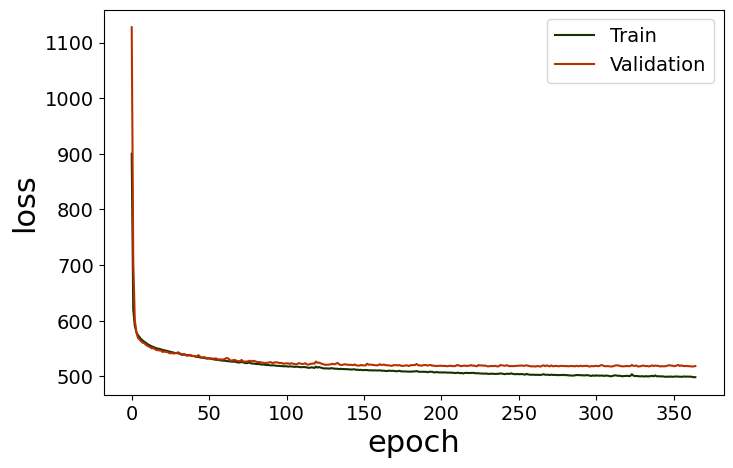

In [ ]:
ddims = 2395
train_df,val_df,test_df=get_splits(
    return_separate=False
    )

customVAE=dVAE(ddims, 128, 0.1, 1e-3).build_vae_keras_model()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
history = customVAE.fit(x=train_df, y=train_df, epochs=5000, batch_size=64, validation_data=(val_df, val_df), callbacks=[callback])
plot_history(history)
customVAE.save_weights('model weights/customVAE2_redo.h5')



In [45]:
customVAE_base = dVAE(ddims, 128, 0.1, 1e-3).build_vae_keras_model_mean()
customVAE_base.load_weights('model weights/customVAE2.h5')

customVAE_after =dVAE(ddims, 128, 0.1, 1e-3).build_vae_keras_model_mean()
customVAE_after.load_weights('model weights/customVAE3.h5')

calculate_differences(customVAE_base, customVAE_after, use_set=0)

Percent change small: -4.10099282584378
Percent change race: -5.357607415703749
Percent change other: -4.360692016434042
Negative value is better. We want the distance to be smaller than before.


In [ ]:
# batch size 128   patience = 100  customVAE  

# batch size 64   patience = 100  customVAE2 (best)
# Percent change small: -0.060714846213428174
# Percent change race: -4.154103291269685
# Percent change other: -0.8736025631097216

# batch size 64   patience = 200  customVAE3
# Percent change small: -0.7816384833012812
# Percent change race: -0.40507856825991034
# Percent change other: -1.675344021143976

In [164]:
customVAE_best = dVAE(ddims, 128, 0.1, 1e-3).build_vae_keras_model_mean()
customVAE_best.load_weights('model weights/customVAE2_redo.h5')
customVAE_best.save_weights('model weights/customVAE_best.h5')


## Improve model to better generate race and small bikes using oversampling

Epoch 1/5000
124/124 [==============================] - 9s 38ms/step - loss: 504.0210 - val_loss: 518.6531
Epoch 2/5000
124/124 [==============================] - 4s 33ms/step - loss: 500.3266 - val_loss: 518.8141
Epoch 3/5000
124/124 [==============================] - 4s 33ms/step - loss: 498.7467 - val_loss: 518.3362
Epoch 4/5000
124/124 [==============================] - 4s 31ms/step - loss: 498.3683 - val_loss: 518.1904
Epoch 5/5000
124/124 [==============================] - 4s 32ms/step - loss: 497.5334 - val_loss: 518.2802
Epoch 6/5000
124/124 [==============================] - 4s 32ms/step - loss: 496.9723 - val_loss: 518.2388
Epoch 7/5000
124/124 [==============================] - 4s 32ms/step - loss: 496.3657 - val_loss: 518.0801
Epoch 8/5000
124/124 [==============================] - 4s 32ms/step - loss: 496.0324 - val_loss: 518.1523
Epoch 9/5000
124/124 [==============================] - 4s 31ms/step - loss: 495.7943 - val_loss: 518.1423
Epoch 10/5000
124/124 [==============

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

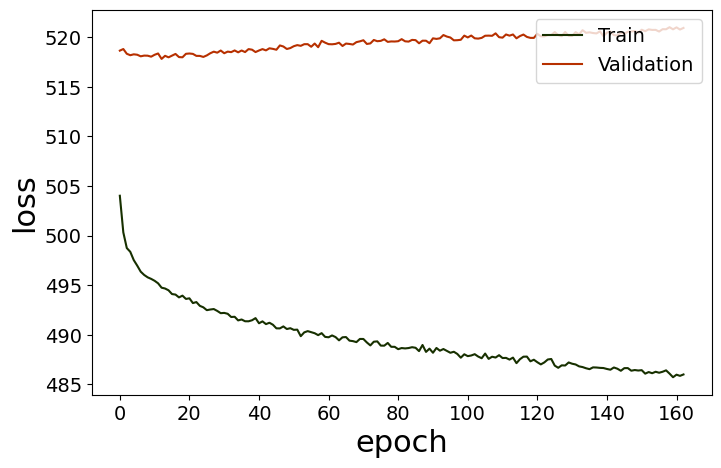

In [180]:
ddims = 2395
(train_small_bikes, train_race_bikes, train_other_bikes,
    val_small_bikes, val_race_bikes, val_other_bikes,
        test_small_bikes, test_race_bikes, test_other_bikes) =get_splits(
            return_separate=True
            )


# Concatenate the original and duplicated DataFrames
train_over_df = pd.concat([
    train_other_bikes,  
    # train_small_bikes, train_small_bikes, train_small_bikes, train_small_bikes, train_small_bikes,
    train_small_bikes, train_small_bikes, train_small_bikes, train_small_bikes, train_small_bikes,  
    train_race_bikes, train_race_bikes, train_race_bikes, train_race_bikes, train_race_bikes, 
    train_race_bikes, train_race_bikes, train_race_bikes, train_race_bikes, train_race_bikes,
    ], 
    ignore_index=True)

# train_over_df = pd.concat([
#     train_small_bikes,  
#     train_race_bikes,
#     ], 
#     ignore_index=True)

# Shuffle the combined dataset
train_over_df = train_over_df.sample(frac=1, random_state=42).reset_index(drop=True)

augmented_customVAE=dVAE(ddims, 128, 0.1, 1e-4).build_vae_keras_model()
augmented_customVAE.load_weights('model weights/customVAE_best.h5')
# freeze_layers_before(augmented_customVAE.get_layer('decoder'), 'd3')
# freeze_layers_before(augmented_customVAE.get_layer('encoder'), 'e3')


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=150)
history = augmented_customVAE.fit(x=train_over_df, y=train_over_df, epochs=5000, batch_size=64, validation_data=(val_df, val_df), callbacks=[callback])

# unfreeze_all_layers(augmented_customVAE)

augmented_customVAE.save_weights('model weights/augmented_customVAE_redo2.h5')
plot_history(history)


# augmented_customVAE = dVAE(ddims, 128, 0.1, 1e-3).build_vae_keras_model_mean()
# augmented_customVAE.load_weights('model weights/augmented_customVAE.h5')


In [182]:
customVAE =dVAE(ddims, 128, 0.1, 1e-3).build_vae_keras_model_mean()
customVAE.load_weights('model weights/customVAE_best.h5')

augmented_customVAE = dVAE(ddims, 128, 0.1, 1e-3).build_vae_keras_model_mean()
augmented_customVAE.load_weights('model weights/augmented_customVAE_redo2.h5')

calculate_differences(customVAE, augmented_customVAE, use_set = 0)

57
36
341
Percent change small: -6.914014588161912
Percent change race: -2.5132946258333244
Percent change other: 1.5901081051984944
Negative value is better. We want the distance to be smaller than before.


In [ ]:
# patience=100 epochs=5000, batch_size=64    X10 x10   augmented_customVAE_redo
# Percent change small: -8.054657206220055
# Percent change race: -2.6925221333708778
# Percent change other: 2.4973349662965494

# patience=100 epochs=5000, batch_size=64    x5 x10   augmented_customVAE_redo1  (best)
# Percent change small: -6.213878461294603
# Percent change race: -3.0709350010559313
# Percent change other: 1.3150200245166452

# patience=150 epochs=5000, batch_size=64    x5 x10   augmented_customVAE_redo2
# Percent change small: -6.914014588161912
# Percent change race: -2.5132946258333244
# Percent change other: 1.5901081051984944

In [183]:
dataVAE =dVAE(ddims, 128, 0.1, 1e-3).build_vae_keras_model_mean()
dataVAE.load_weights('model weights/dataVAE.h5')

augmented_customVAE = dVAE(ddims, 128, 0.1, 1e-3).build_vae_keras_model_mean()
augmented_customVAE.load_weights('model weights/augmented_customVAE_redo2.h5')

calculate_differences(dataVAE, augmented_customVAE, use_set = 2)

55
31
328
Percent change small: -6.57512643034282
Percent change race: -3.5136428992136843
Percent change other: 0.2569506812670111
Negative value is better. We want the distance to be smaller than before.


In [184]:
customVAE_best = dVAE(ddims, 128, 0.1, 1e-3).build_vae_keras_model_mean()
customVAE_best.load_weights('model weights/augmented_customVAE_redo1.h5')
customVAE_best.save_weights('model weights/augmented_customVAE_best.h5')

In [ ]:
# (train_small_bikes, train_race_bikes, train_other_bikes,
#     val_small_bikes, val_race_bikes, val_other_bikes,
#         test_small_bikes, test_race_bikes, test_other_bikes) = create_splits(small_bikes_df, 
#                                                                             race_bikes_df,
#                                                                             other_bikes_df,
#                                                                             True)

test_small = dtest.loc[dtest.index.isin(test_small_bikes.index) ]
test_race = dtest.loc[dtest.index.isin(test_race_bikes.index)   ]
test_other = dtest.loc[dtest.index.isin(test_other_bikes.index) ]


dataVAE =dVAE(ddims, 128, 0.1, 1e-3).build_vae_keras_model_mean()
dataVAE.load_weights('model weights/dataVAE.h5')

customVAE =dVAE(ddims, 128, 0.1, 1e-3).build_vae_keras_model_mean()
customVAE.load_weights('model weights/customVAE.h5')

augmented_customVAE = dVAE(ddims, 128, 0.1, 1e-3).build_vae_keras_model_mean()
augmented_customVAE.load_weights('model weights/augmented_customVAE.h5')


encoder =  dataVAE.get_layer('encoder')
decoder = dataVAE.get_layer('decoder')
latent_data_small = encoder.predict(test_small)  
latent_data_race = encoder.predict(test_race)  
latent_data_other = encoder.predict(test_other)  
res_small = (tf.math.sigmoid(decoder.predict(latent_data_small))).numpy()  
res_race = (tf.math.sigmoid(decoder.predict(latent_data_race))).numpy()  
res_other = (tf.math.sigmoid(decoder.predict(latent_data_other))).numpy()  
indexnames_small = [f'small_{i}_data' for i in test_small.index]
indexnames_race =   [f'race_{i}_data' for i in test_race.index]
indexnames_other = [f'other_{i}_data' for i in test_other.index]
data_regen_df_small = pd.DataFrame(data=res_small, index=indexnames_small, columns=dfn.columns)  
data_regen_df_race = pd.DataFrame(data=res_race, index=indexnames_race, columns=dfn.columns)  
data_regen_df_other = pd.DataFrame(data=res_other, index=indexnames_other, columns=dfn.columns)  

encoder =  customVAE.get_layer('encoder')
decoder = customVAE.get_layer('decoder')
latent_data_small = encoder.predict(test_small)  
latent_data_race = encoder.predict(test_race)  
latent_data_other = encoder.predict(test_other)  
res_small = (tf.math.sigmoid(decoder.predict(latent_data_small))).numpy()  
res_race = (tf.math.sigmoid(decoder.predict(latent_data_race))).numpy() 
res_other = (tf.math.sigmoid(decoder.predict(latent_data_other))).numpy()  
indexnames_small = [f'small_{i}_custom' for i in test_small.index]
indexnames_race =  [f'race_{i}_custom' for i in test_race.index]
indexnames_other = [f'other_{i}_custom' for i in test_other.index]
custom_regen_df_small = pd.DataFrame(data=res_small, index=indexnames_small, columns=dfn.columns) 
custom_regen_df_race= pd.DataFrame(data=res_race, index=indexnames_race, columns=dfn.columns) 
custom_regen_df_other = pd.DataFrame(data=res_other, index=indexnames_other, columns=dfn.columns)  


encoder =  augmented_customVAE.get_layer('encoder')
decoder = augmented_customVAE.get_layer('decoder')
latent_data_small = encoder.predict(test_small)  
latent_data_race = encoder.predict(test_race)  
latent_data_other = encoder.predict(test_other)  
res_small = (tf.math.sigmoid(decoder.predict(latent_data_small))).numpy()  
res_race = (tf.math.sigmoid(decoder.predict(latent_data_race))).numpy() 
res_other = (tf.math.sigmoid(decoder.predict(latent_data_other))).numpy()  
indexnames_small = [f'small_{i}_aug' for i in test_small.index]
indexnames_race =  [f'race_{i}_aug' for i in test_race.index]
indexnames_other = [f'other_{i}_aug' for i in test_other.index]
augmented_customVAE_regen_df_small = pd.DataFrame(data=res_small, index=indexnames_small, columns=dfn.columns) 
augmented_customVAE_regen_df_race= pd.DataFrame(data=res_race, index=indexnames_race, columns=dfn.columns) 
augmented_customVAE_regen_df_other = pd.DataFrame(data=res_other, index=indexnames_other, columns=dfn.columns)  


data_regen_df_small.to_csv(f"../data/temp.csv") 
processGen.processGen(f"temp", denorm=True)
data_regen_df_race.to_csv(f"../data/temp.csv") 
processGen.processGen(f"temp", denorm=True)
data_regen_df_other.to_csv(f"../data/temp.csv") 
processGen.processGen(f"temp", denorm=True)

custom_regen_df_small.to_csv(f"../data/temp.csv") 
processGen.processGen(f"temp", denorm=True)
custom_regen_df_race.to_csv(f"../data/temp.csv") 
processGen.processGen(f"temp", denorm=True)
custom_regen_df_other.to_csv(f"../data/temp.csv") 
processGen.processGen(f"temp", denorm=True)

augmented_customVAE_regen_df_small.to_csv(f"../data/temp.csv") 
processGen.processGen(f"temp", denorm=True)
augmented_customVAE_regen_df_race.to_csv(f"../data/temp.csv") 
processGen.processGen(f"temp", denorm=True)
augmented_customVAE_regen_df_other.to_csv(f"../data/temp.csv") 
processGen.processGen(f"temp", denorm=True)

clear_output(wait = False)

### Which sets are my bikes in?

In [ ]:
train_df,val_df,test_df=get_splits(
    return_separate=False
    )

print("Final usable bikes for train set:")
print(train_df.loc[train_df.index.isin(usable_bikes.index)].index.tolist())
print("\nFinal unusable bikes for train set:")
print(train_df.loc[train_df.index.isin(unusable_bikes.index)].index.tolist())

print("Final usable bikes for val set:")
print(val_df.loc[val_df.index.isin(usable_bikes.index)].index.tolist())
print("\nFinal unusable bikes for val set:")
print(val_df.loc[val_df.index.isin(unusable_bikes.index)].index.tolist())

print("Final usable bikes for test set:")
print(test_df.loc[test_df.index.isin(usable_bikes.index)].index.tolist())
print("\nFinal unusable bikes for test set:")
print(test_df.loc[test_df.index.isin(unusable_bikes.index)].index.tolist())



Final usable bikes for train set:
[301, 4031, 4218, 2625, 1268, 2451, 1067, 9, 3820, 650, 3804, 159, 2100, 605, 253, 3134, 4672, 4785, 1988, 308, 4164, 4407, 3208, 3911, 1149, 2839, 4436, 4172, 4600, 1013, 1303, 1698, 3730, 1642, 4144, 2343, 3361, 2836, 4249]

Final unusable bikes for train set:
[4682, 4050, 4658, 390, 1461, 2764, 4522, 3184, 2910, 4538, 3567, 2652, 3962, 1285, 1210, 3379, 2939, 1583, 2612, 1842, 2821, 3822, 1783, 1656, 2827, 675, 3025, 3071, 4256, 752, 4105, 1336, 1903, 3030, 433, 4065, 3223, 312, 3092, 4566, 881]
Final usable bikes for val set:
[]

Final unusable bikes for val set:
[]
Final usable bikes for test set:
[1251, 2865, 3897, 341, 1443, 572, 4277, 23, 1837, 3854]

Final unusable bikes for test set:
[2738, 4696, 1383, 1246, 1771, 2635, 2087, 3927, 3012, 4094]
